Estimate the integral $\int_0 ^1 {exp(x)dx}$ by simulation (the crude Monte Carlo
estimator). Use eg. an estimator based on 100 samples and present
the result as the point estimator and a confidence interval.

The variance of a mean estimate is $Var(\bar{X}) = \frac{\sigma^2}{n}$

In [31]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.integrate as integrate
import scipy.special as special

n = 100
U = np.random.uniform(0,1,size=n)
#trf 
X = np.exp(U)
theta = np.mean(X)
print(theta)

theoretical_numeric = integrate.quad(lambda x: np.exp(x),0,1)

#error 
print(f"Error is: {abs(theta-theoretical_numeric[0])}")

#get CI 
V = np.var(X)/len(U) #get variance of mean-estimator 
CI = st.norm.interval(0.95,loc=theta,scale=np.sqrt(V))
print("CI IS: ",CI)
print("Width is: ",CI[1]-CI[0])


1.703039317318659
Error is: 0.015242511140386217
CI IS:  (1.6087506738104682, 1.79732796082685)
Width is:  0.18857728701638177


<h>(2)</h>

Estimate the integral $\int_0 ^1 {exp(x)dx}$ using antithetic variables, with comparable computer ressources.

In [33]:
Z = np.exp(1-U)
Y = (X+Z)/2
theta_ath = np.mean(Y)
print(theta_ath)
V = np.var(Y)/n
CI = st.norm.interval(0.95,loc=theta_ath,scale=np.sqrt(V))
print("Error is: ",abs(theta_ath-theoretical_numeric[0]))
print("CI IS: ",CI)
print("Width is: ",CI[1]-CI[0])

1.7168595724697888
Error is:  0.0014222559892564934
CI IS:  (1.7039679685291063, 1.7297511764104714)
Width is:  0.025783207881365122


CI is an order of magnitude smaller.

<h1>(3)</h1>

Estimate $\int_0 ^1 {exp(x)dx}$ using a control variable, with
comparable computer ressources

In [73]:
#with mean-expression for covariance
cov = np.mean(U*X)-np.mean(U)*np.mean(X)
c = -cov/np.var(U)
Z = X+c*(U-1/2) #expectancy of uniform
theta_control = np.mean(Z)
print(theta_control)
var_control = (np.var(X)-(cov**2/np.var(U)))/n
print(var_control)
#get CI
CI = st.norm.interval(0.95,loc=theta_control,scale=np.sqrt(var_control))
print("Error is: ",abs(theta_control-theoretical_numeric[0]))
print("CI IS: ",CI)
print("Width is: ",CI[1]-CI[0])


#try with direct empirical covariance estimate
cov_emp = np.cov(X,U)[0,-1]
c = -cov_emp/np.var(U)
Z = X+c*(U-1/2) #expectancy of uniform
#estimate 
theta_control_emp = np.mean(Z)
print(theta_control_emp)
#estimate var
var_control = (np.var(X)-(cov_emp**2/np.var(U)))/n
CI = st.norm.interval(0.95,loc=theta_control_emp,scale=np.sqrt(var_control))
print("Error is: ",abs(theta_control_emp-theoretical_numeric[0]))
print("CI IS: ",CI)
print("Width is: ",CI[1]-CI[0])


1.716233878259134
4.226988699236878e-05
Error is:  0.0020479501999113303
CI IS:  (1.7034911144209166, 1.7289766420973514)
Width is:  0.02548552767643475
1.7163671566524712
Error is:  0.0019146718065741197
CI IS:  (nan, nan)
Width is:  nan


/tmp/ipykernel_16006/374538268.py:25: RuntimeWarning: invalid value encountered in sqrt
  CI = st.norm.interval(0.95,loc=theta_control_emp,scale=np.sqrt(var_control))


Trying with an empirical direct covariance-estimate is not as robust, and in this case fails. Probably better with larger n.

When using the mean-method for computing covariance, we notice a marginal decrease in the width of the CI.

<h>(4)</h>

Estimate the integral $\int_0 ^1 {exp(x)dx}$ using stratified sampling with comparable compute

In [119]:
#make uniform chunks 
NSTRATA = 10
Ui = np.split(U/10,NSTRATA)
W = np.zeros((NSTRATA,1))

#Fill W
for i in range(NSTRATA):
    seqsum = 0.0
    for j in range(NSTRATA):
        constant_factor = j*1/NSTRATA
        seqsum += np.exp(constant_factor + Ui[j][i])
    W[i] = seqsum/NSTRATA

def get_estimate_and_CI(X,var,theoretical):
    theta = np.mean(X)
    print("Mean is: ",theta)
    CI = st.norm.interval(0.95,loc=theta,scale=np.sqrt(var))
    print("Error is: ",abs(theta-theoretical))
    print("CI IS: ",CI)
    width = CI[1]-CI[0]
    print("Width is: ",width) 
    return theta, width

#ESTIMATE
varSTRAT = np.var(W)/NSTRATA 
thetaSTRAT,widthSTRAT = get_estimate_and_CI(W,varSTRAT,theoretical_numeric[0])  


Mean is:  1.714834705435814
Error is:  0.0034471230232313577
CI IS:  (1.7058020594323993, 1.7238673514392286)
Width is:  0.01806529200682938


Stratified sampling seems to reduce the width even more.

<h1>(5)Use control variates to reduce the variance of the estimator in exercise 4 (Poisson arrivals)</h1>

Want: estimated fraction X, return arrival times (U) and expectancy of arrival time, service times and expectancy of service times (V)

In [216]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st

class customerSimulationModified:
    def __init__(self,n_customers,mean_arrival_time,n_cashiers,mean_service_time,n_experiments,arrivalmode=None,servicemode=None,experimentMode = None):
        self.arrivalData = [] #to save used distributions for variance reduction
        self.serviceData = [] #to save for variance reduction
        self.meanArrivalTime = mean_arrival_time
        self.meanServiceTime = mean_service_time
        self.experimentMode = experimentMode
        self.n_c = n_customers
        self.cashier_capacity = n_cashiers
        self.cashiers_occupied = 0
        self.clock = 0 #arbitrary time-unit
        self.n_e = n_experiments
        self.n_rejected = 0
        self.CASHIERS_FREE = True
        self.cashier_time = []
        self.total_customers = n_experiments*n_customers
        self.seed = 0
        self.rng = None
        self.update_generator()
        self.arrivalTimes = self.initialize_arrivals(mean_arrival_time,arrivalmode)
        self.departureTimes = self.initialize_departures(mean_service_time,servicemode)
        self.rejected_results = [] #holds number rejected for experiments 
        self.clockResults = []
        self.arrivalMode = arrivalmode
        self.serviceMode = servicemode
        
        
        
    def update_generator(self):
        self.seed += 1
        self.rng = np.random.default_rng(seed=self.seed)
        return None
    
    def initialize_arrivals(self,mat,arrivalmode=None):
        if(arrivalmode==None and self.experimentMode==None):
            X = self.rng.poisson(lam=mat,size=self.n_c)
            self.arrivalData.append(X)
            X = X.tolist()
            return X
        elif(arrivalmode==None and self.experimentMode=="controlledvariables"):
            X = self.castUniformToPoisson()
            self.arrivalData.append(X)
            X = X.tolist()
            return X
        elif(arrivalmode=="erlang"):
            mean = 1
            shape_k = 1
            X = np.random.gamma(shape=shape_k,scale=mean,size=self.n_c)
            self.arrivalData.append(X)
            X = X.tolist()
            return X
        elif(arrivalmode=="hyperexponential"):
            p = 0.8
            lambda1 = 0.833333
            lambda2 = 5.0
            X = np.zeros(self.n_c)
            P = self.rng.uniform(0,1,size=self.n_c)
            X[P <= p] = -np.log(1-np.random.uniform(0,1,size=(P <= p).sum()))/lambda1
            X[P > p]  = -np.log(1-np.random.uniform(0,1,size=(P >  p).sum()))/lambda2
            self.arrivalData.append(X)
            return X.tolist()
    def castUniformToPoisson(self): 
        #Generates poisson from uniform using Ross 4.2)
        lamb = self.meanArrivalTime
        p_org = np.exp(-lamb)
        F_org = p_org
        n_samples = self.n_c
        holder = []
        while(len(holder)<n_samples):
            X = self.rng.uniform()
            i = 0
            p = p_org
            F = F_org
            if(X<F):
                holder.append(i)
            else:
                while(X>=F):
                    p = lamb*p/(i+1)
                    F = F+p
                    i += 1
                holder.append(i)
        return np.array(holder)

                
    def initialize_departures(self,mst,servicemode=None):
        if(servicemode==None):
            X = self.rng.exponential(scale=mst,size=self.n_c)
        elif(servicemode=="constant"):
            X = [mst for x in range(self.n_c)]
            self.serviceData.append(np.array(X))
            return X
        elif(servicemode=="pareto1"):
            k = 1.05
            X = st.pareto.rvs(k,scale=mst*(k-1)/k,size=self.n_c)
        elif(servicemode=="pareto2"):
            k = 2.05
            X = st.pareto.rvs(k,scale=mst*(k-1)/k,size=self.n_c)
        elif(servicemode=="uniform"):
            X = 2*mst*np.random.uniform(size=self.n_c)
        self.serviceData.append(X)
        return X.tolist()
        
    
    def reinitialize(self):
        self.update_generator()
        self.clock = 0
        self.n_rejected = 0
        self.cashier_time = []
        self.arrivalTimes = self.initialize_arrivals(self.meanArrivalTime,self.arrivalMode)
        self.departureTimes = self.initialize_departures(self.meanServiceTime,self.serviceMode)
        return None
    
    def get_next_event(self):
        ###Extracts arrival time and departure-time and removes entries from event-lists
        at = self.arrivalTimes[0]
        dt = self.departureTimes[0]
        self.arrivalTimes.pop(0)
        self.departureTimes.pop(0)
        return at,dt
    
    def assign_to_cashier(self,arrivalt,departuret):
        self.cashier_time = [x-arrivalt for x in self.cashier_time] #update passed time
        self.cashier_time = [x for x in self.cashier_time if x>0] #remove from cashier if service has been finished
        if(len(self.cashier_time)==self.cashier_capacity): #all cashiers are busy - reject customer 
            self.n_rejected += 1 
        else:
            self.cashier_time.append(departuret)
        return None
            
    def runSim(self):
        while(len(self.arrivalTimes)>0):
            at,dt = self.get_next_event()
            old_clock = self.clock
            self.clock += at
            self.assign_to_cashier(at,dt)
            #update cashier time 
        self.rejected_results.append(self.n_rejected)
        self.clockResults.append(self.clock)
        return None
    
    def runSimMultiple(self,n_experiments):
        self.runSim() #already initialized
        for i in range(n_experiments-1):
            self.reinitialize()
            self.runSim()
        return None
    
    def printResults(self):
        print(f"Number of rejected customers: {self.rejected_results}")
        print(f"Clock time for finished service: {self.clockResults}")
        return None
    
    def getRejectedResults(self):
        return self.rejected_results
    
    def getClockResults(self):
        return self.clockResults
            
    def getTheoreticalRejectedResult(self):
        A = self.meanArrivalTime*self.meanServiceTime
        numerator = (A**self.cashier_capacity)/np.math.factorial(self.cashier_capacity)
        denominator = sum([(A**i)/np.math.factorial(i) for i in range(self.cashier_capacity+1)])
        return numerator/denominator
        
    def extractStatistic(self,descriptor,alpha):
        if(descriptor=="clock"):
            theta = self.clockResults
        elif(descriptor=="rejections"):
            theta = self.rejected_results
        
        #estimate mean on per-experiment basis 
        theta_mean = [x/self.n_c for x in theta] #get per-experiment fraction
        #print(theta_mean)
        #estimate fraction across number of experiments 
        theta_exp_mean = sum(theta_mean)/self.n_e
        #print(theta_exp_mean)
        squared_diff = [x**2 - theta_exp_mean**2 for x in theta_mean]
        #print(squared_diff)
        var = 1/(self.n_e-1)*sum(squared_diff)
        #print(var)
        ci_val = (np.sqrt(var)/np.sqrt(self.n_e))*st.t.interval(confidence=alpha,df=self.n_e-1)[1] #positive entry
        CIL = [theta_exp_mean - ci_val, theta_exp_mean + ci_val]
        width = CIL[1]-CIL[0]
        return theta_exp_mean,var,CIL,width
    
    def printStatisticResults(self):
        if(self.arrivalMode!=None):
            title = self.arrivalMode
        elif(self.serviceMode!=None):
            title = self.serviceMode
        else:
            title = "Poisson arrival / exponential service"
        thetaMeasured, varianceMeasured, confint, cwidth = self.extractStatistic("rejections",0.95)
        print(f"{title} results")
        print(f"Estimated fraction of blocked customers: {thetaMeasured}")
        print(f"Estimated variance of estimate: {varianceMeasured}")
        print(f"95% Confidence-Interval (low,high): {confint}")
        print(f"Width of CI: {cwidth}")

        return None
    
    def getMeans(self):
        theta = self.rejected_results
        return np.array([x/self.n_c for x in theta])
    

Generate 10 simulations

In [171]:
NEXP = 10
SIM = customerSimulationModified(10000,1,10,8,10,arrivalmode=None,servicemode=None)
SIM.runSimMultiple(n_experiments=NEXP)
SIMmeans = SIM.getMeans()
serviceData = SIM.serviceData
arrivalData = SIM.arrivalData

#get results of simulation without variance-reduction
theta_SIM_vanilla,var_SIM_vanilla,CIL_SIM_vanilla,width_SIM_VANILLA = SIM.extractStatistic(descriptor="rejections",alpha=0.95)

In [172]:
expectancy_arrival = 1
expectancy_service = 8

#get mean per-experiment arrival-times and service-times
mean_arrivals = np.zeros((NEXP,1))
mean_services = np.zeros((NEXP,1))
for i in range(NEXP):
    mean_arrivals[i] = np.mean(arrivalData[i])
    mean_services[i] = np.mean(serviceData[i])

#construct variable using control-variate
#1) get optimal constants
#cov_arrival = np.mean(SIMmeans*mean_arrivals)-np.mean(SIMmeans)*np.mean(mean_arrivals)
mean_arrivals = np.squeeze(mean_arrivals,-1)
mean_services = np.squeeze(mean_services,-1)
cov_arrival = np.cov(SIMmeans,mean_arrivals)[0,1]
c1 = -cov_arrival/np.var(mean_arrivals)

#cov_service = np.mean(SIMmeans*mean_services)-np.mean(SIMmeans)*np.mean(mean_services)
cov_service = np.cov(SIMmeans,mean_services)[0,1]
c2 = -cov_service/np.var(mean_services)

#2) construct control variate
Z = SIMmeans+c1*(mean_arrivals-expectancy_arrival)+c2*(mean_services-expectancy_service)

#estimate var
var_control_SIM = np.var(SIMmeans)-(cov_arrival**2/np.var(mean_arrivals))/NEXP - (cov_service**2/np.var(mean_services))/NEXP
var_control_SIM /= NEXP #10 experiments

#get estimate and CI 
thetaSIM,widthSIM = get_estimate_and_CI(Z,var_control_SIM,theta_SIM_vanilla) 
#we get the same result but the with of the CI is
print("Variance reduction: ", widthSIM-width_SIM_VANILLA)

Mean is:  0.1287592587270675
Error is:  0.002060741272932487
CI IS:  (0.12473935018978688, 0.13277916726434813)
Width is:  0.00803981707456125
Variance reduction:  -0.0024892602636942818


We get a marginally more narrow confidence interval, and the estimates are close.

<h>(6)</h>

 Demonstrate the effect of using common random numbers in
exercise 4 for the difference between Poisson arrivals (Part 1) and a
renewal process with hyperexponential interarrival times


First, I have rewritten the generation scheme for the poisson-distribution to use a seeded uniform distribution and cast to poisson (using Ross, C4.2). The generation of the hyperexponential is seeded with the same seed. Thus, we should be able to conduct the experiment:

In [217]:
NEXP = 10
SIMPOIS = customerSimulationModified(10000,1,10,8,10,arrivalmode=None,servicemode=None,experimentMode="controlledvariables")
SIMPOIS.runSimMultiple(n_experiments=NEXP)
SIMmeansPOIS = SIMPOIS.getMeans()

SIMHYP = customerSimulationModified(10000,1,10,8,10,arrivalmode="hyperexponential",servicemode=None,experimentMode="controlledvariables")
SIMHYP.runSimMultiple(n_experiments=NEXP)
SIMmeansHYP = SIMHYP.getMeans()

#comparison 
diff = np.mean(SIMmeansPOIS)-np.mean(SIMmeansHYP)
print(diff)

-0.009190000000000004


In [183]:
print(SIMmeansPOIS)

[0.999  0.9989 0.9989 0.9988 0.9988 0.999  0.999  0.9989 0.9989 0.999 ]


So it seems that if arrivals are poisson, the mean fraction of rejections is a bit smaller than if they are hyperexponential 

<h>(7)</h>

For a standard normal random variable Z ∼ N(0, 1) using the crude
Monte Carlo estimator estimate the probability Z > a. Then try
importance sampling with a normal density with mean a and
variance σ2
For the expirements start using σ2 = 1, use different
values of a (e.g. 2 and 4), and different sample sizes. If time permits experiment with other values for σ2
Finally discuss the
efficiency of the methods.

Text(0.5, 1.0, 'Crude MC')

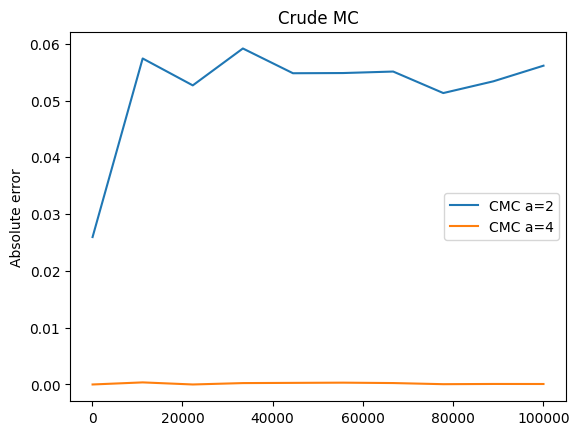

In [66]:
import numpy as np 
import scipy.stats as st
import scipy 
import matplotlib.pyplot as plt

def theoretical_norm(a):
    # Normal distribution Z - N(0,1), what is P(Z>a)?
    return scipy.integrate.quad(lambda z: normal_z(z),a,np.inf)[0]
    

def eval_error_norm(appx,a):
    theoretical = theoretical_norm(a)
    error = abs(theoretical-appx)
    print("error is: ",error)
    return error


def normal_z(z):
    return 1/np.sqrt(2*np.pi)*np.exp(-0.5*z**2) #has been debugged, works fine

def importanceSamplingNormal(a,var,nsamples):
    #https://www.math.arizona.edu/~tgk/mc/book_chap6.pdf
    
    #nominal distribution: normal
    #sampling distribution: exponential
    Y = np.random.exponential(1,size=nsamples)
    std = np.sqrt(var)
    q = np.exp(-Y+a)
    q[Y<a] = 0
    Z = (Y-a)/std
    #seqsum = 0
    return np.mean(1/std*normal_z(Z[Y>a])/q[Y>a])


def crude_MC_estimator_norm(a,nsamples):
    X = np.random.normal(size=nsamples)
    return np.sum(X[X>a])/len(X)


nsamples = np.linspace(100,100000,10).astype(int)
a1 = 2
a2 = 4
var = 1
error_eval = lambda x: abs(x-0.5)
errors1 = []
errors2 = []
errorsCMC1 = []
errorsCMC2 = []
for n in nsamples:
    errors1.append(error_eval(importanceSamplingNormal(a1,var,n)))
    errors2.append(error_eval(importanceSamplingNormal(a2,var,n)))
    errorsCMC1.append(crude_MC_estimator_norm(a1,n))
    errorsCMC2.append(crude_MC_estimator_norm(a2,n))




plt.figure()
plt.plot(nsamples,errors1,label="a=2")
plt.plot(nsamples,errors2,label="a=4")
plt.ylabel("Absolute error")
plt.legend()
plt.title("Importance sampling")

plt.figure()
plt.plot(nsamples,errorsCMC1,label="CMC a=2")
plt.plot(nsamples,errorsCMC2,label="CMC a=4")
plt.ylabel("Absolute error")
plt.legend()
plt.title("Crude MC")


